In [ ]:
import time
import torch
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [ ]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


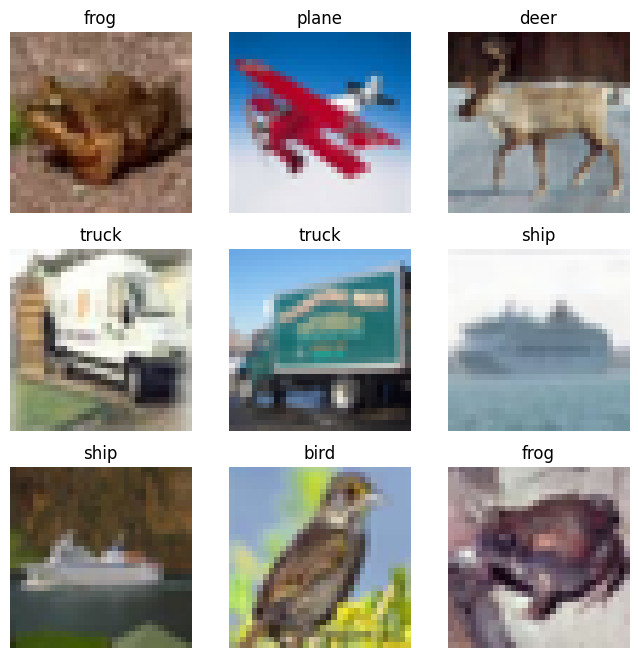

In [ ]:
labels_map = {
    0: "plane",
    1: "car",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    img = img.permute(1, 2, 0).numpy()

    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()


In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    avg_loss = []
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        avg_loss.append(loss.item())

    #print("[Train] Loss: %.4f , Iter time: %.4f ms" % (np.mean(avg_loss), 1000*np.mean(avg_time)))
    return np.mean(avg_loss)


def test_loop(dataloader, model, loss_fn, device):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    #print("[Test]  Loss: %.4f , Accuracy: %.2f" % (np.mean(test_loss), 100*correct))
    return np.mean(test_loss), correct*100


def log_results(train_loss_list, test_loss_list, test_acc_list):
    # 시각화
    plt.figure(figsize=(10, 5))

    # 1. x축 (epoch), y축 (train_loss & test_loss)
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_list, label='train_loss')
    plt.plot(test_loss_list, label='test_loss')
    plt.title('Train and Test Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. x축 (epoch), y축 (test_acc)
    plt.subplot(1, 2, 2)
    plt.plot(test_acc_list, label='test_acc')
    plt.title('Test Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
# fixed settings
num_classes = 10
device = 'cuda'
test_dataloader = DataLoader(test_data, batch_size=64, num_workers=2, pin_memory=True)
loss_fn = nn.CrossEntropyLoss()

Start training


100%|██████████| 20/20 [03:17<00:00,  9.88s/it]


Done!


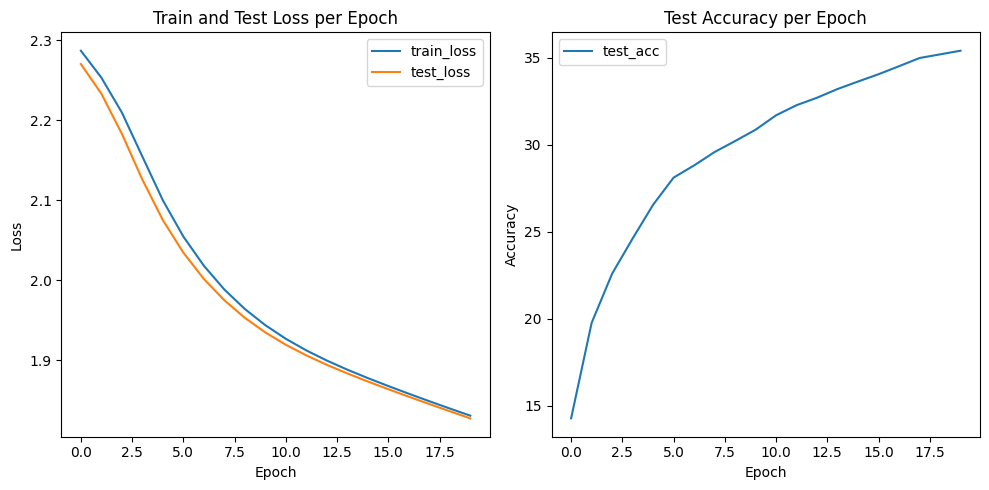

In [ ]:
# MLP

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0
train_dataloader = DataLoader(training_data, batch_size=batch_size)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

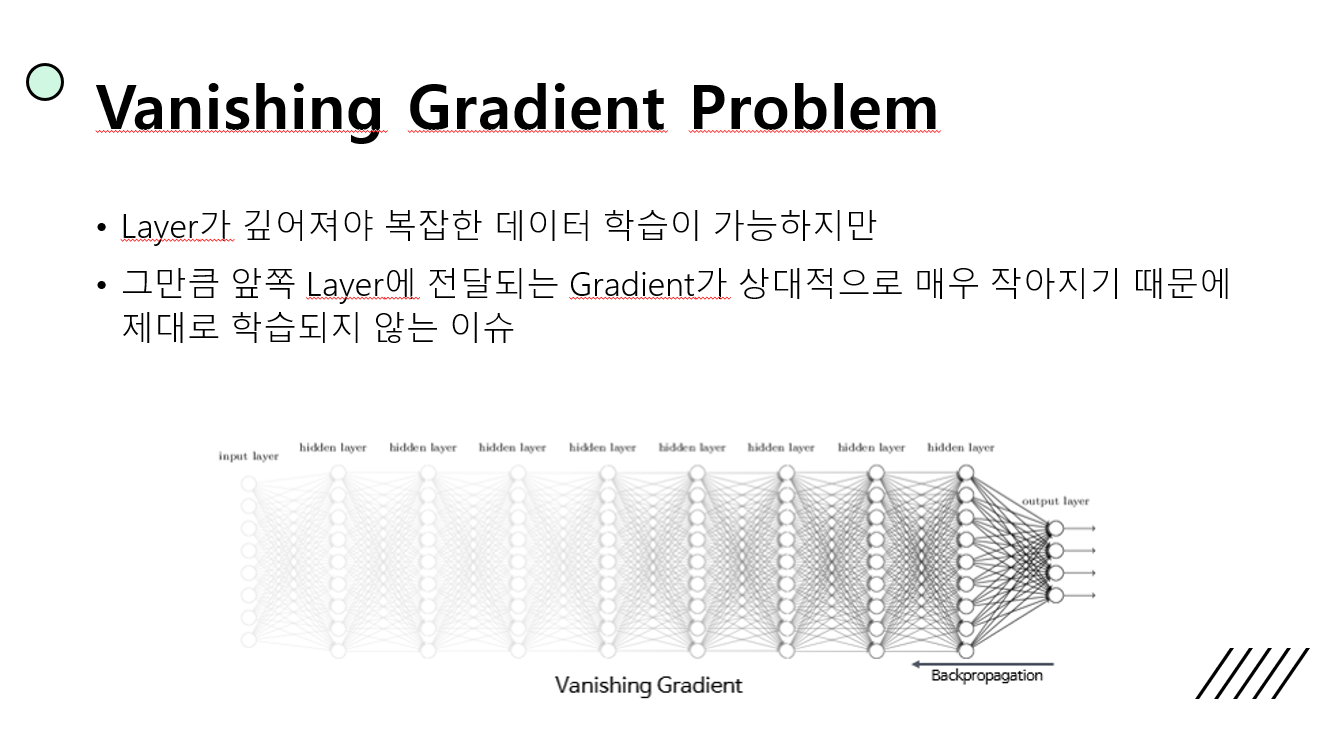

Start training


100%|██████████| 20/20 [03:10<00:00,  9.55s/it]


Done!


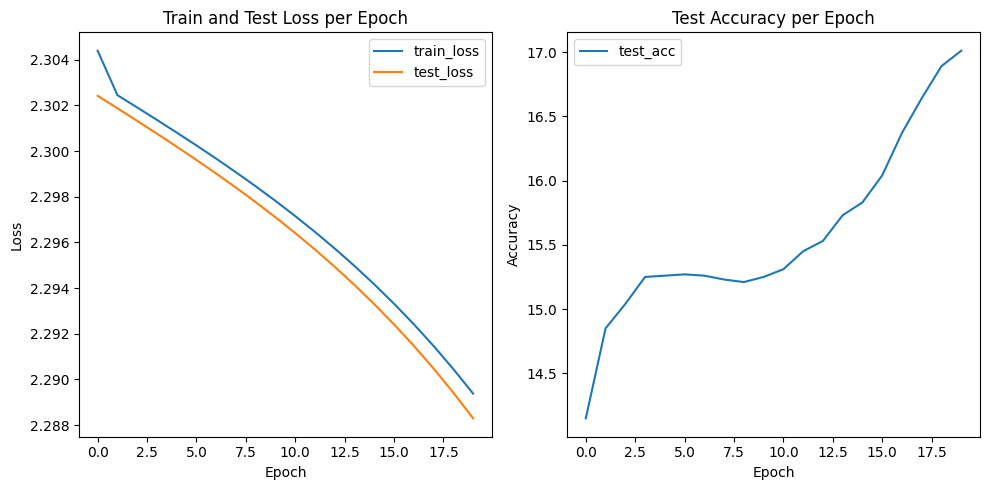

In [ ]:
# Vanishing Gradient Problem

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.Sigmoid(),
            nn.Linear(512, 512),
            nn.Sigmoid(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

Start training


100%|██████████| 20/20 [03:21<00:00, 10.10s/it]


Done!


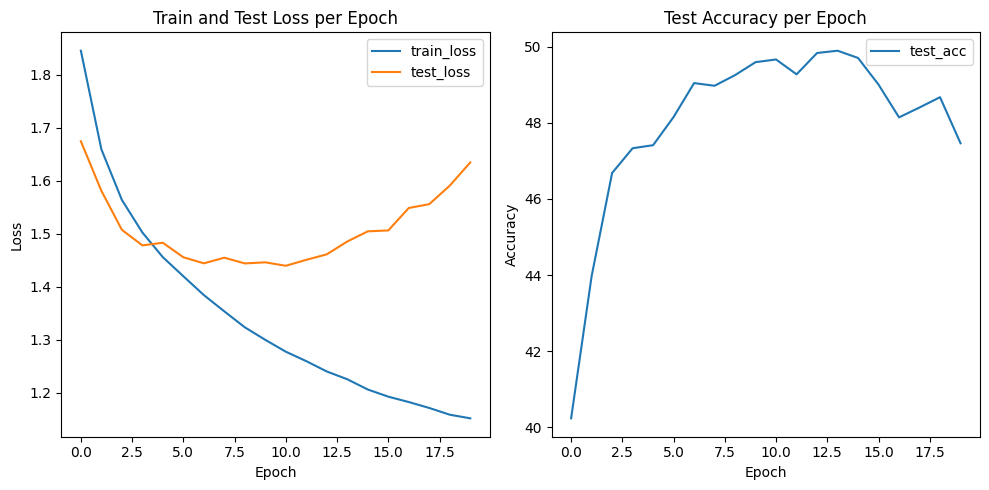

In [ ]:
# Adam optimizer

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

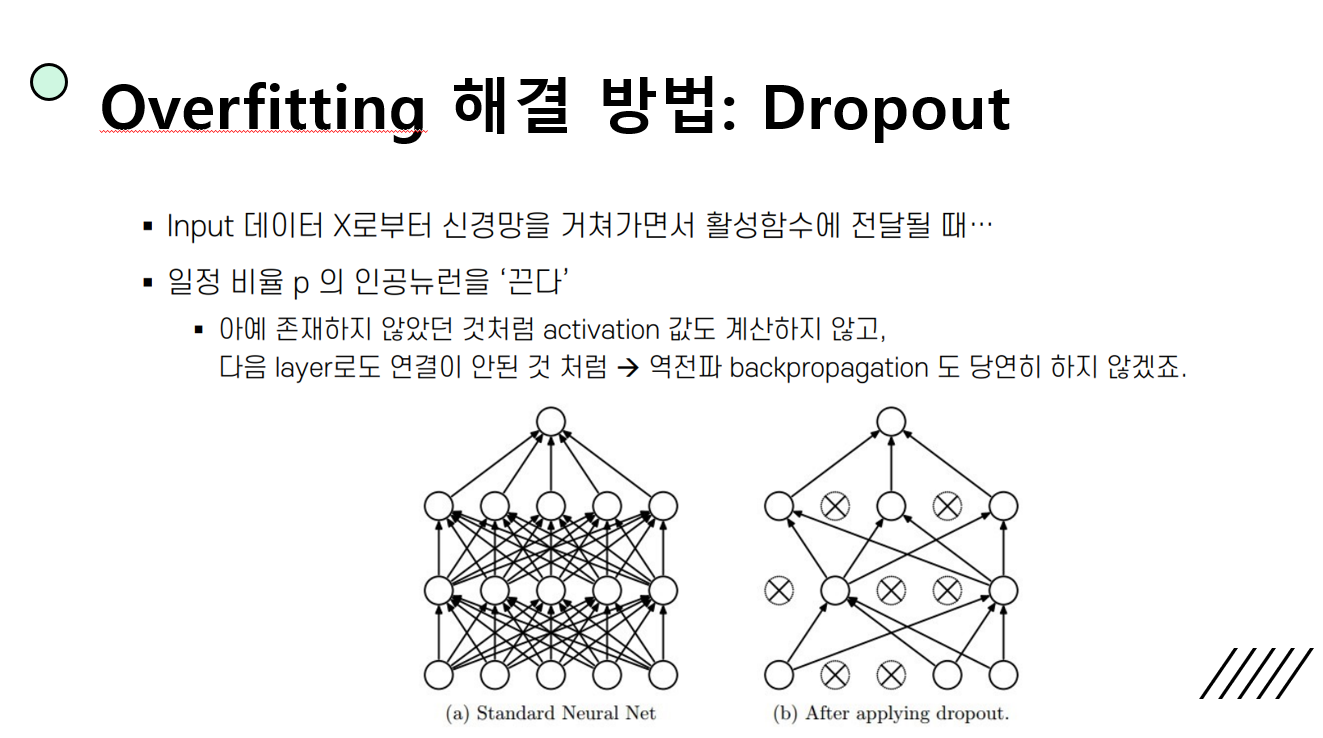

Start training


100%|██████████| 20/20 [11:03<00:00, 33.17s/it]


Done!


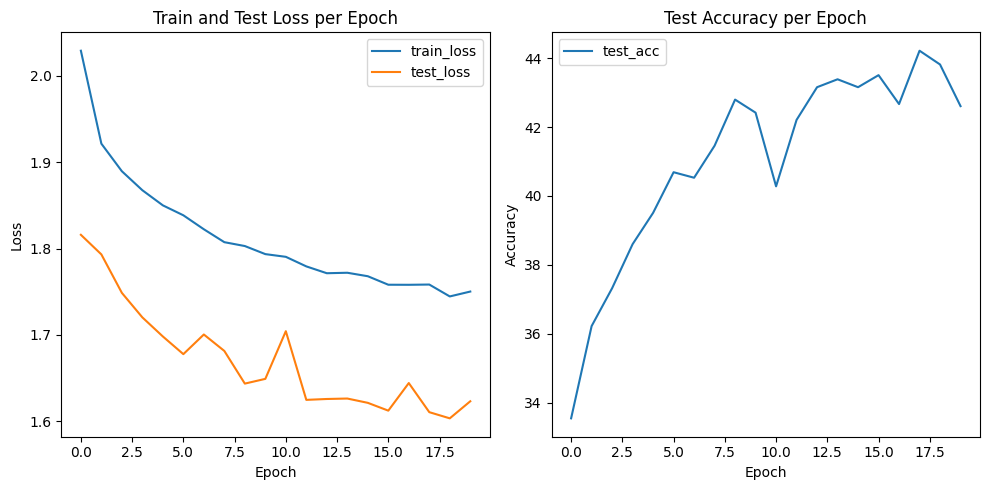

In [ ]:
# Dropout

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Dropout(p=0.25),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

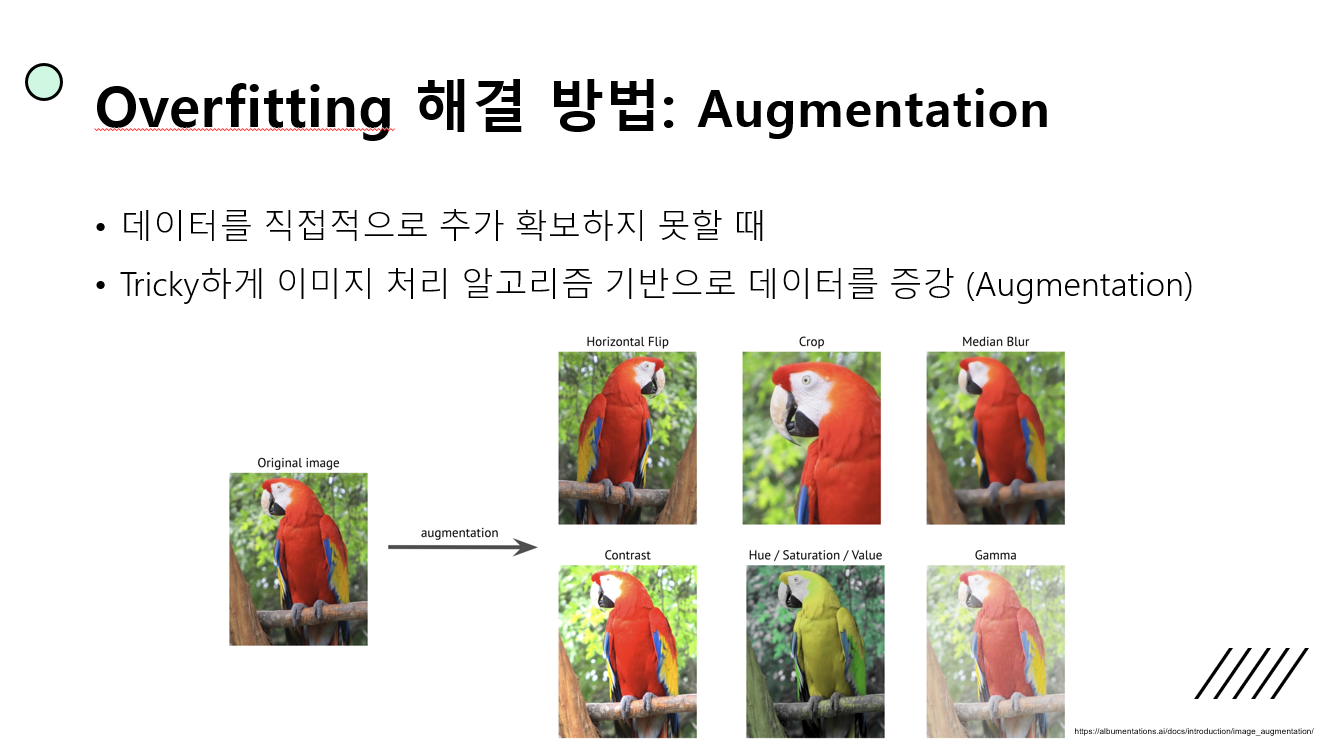

Files already downloaded and verified
Start training


100%|██████████| 20/20 [13:12<00:00, 39.61s/it]


Done!


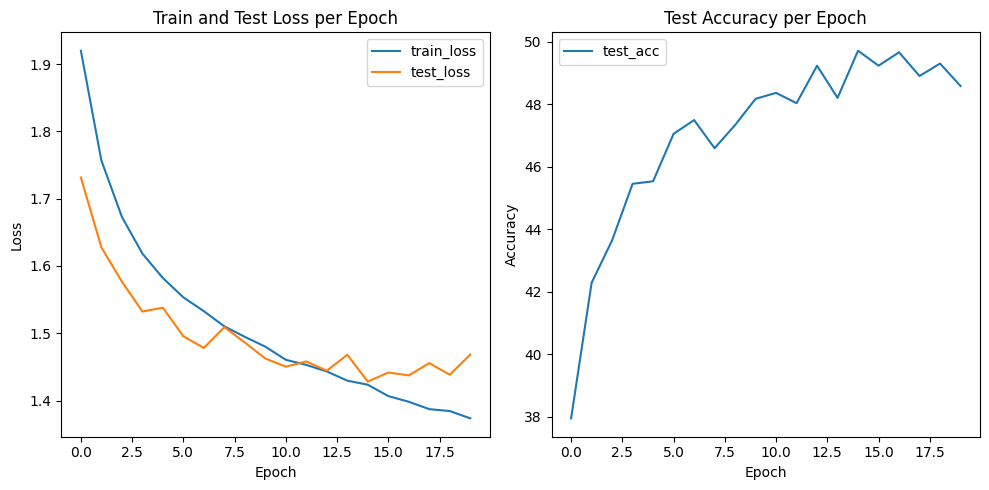

In [ ]:
# Image Agumentation

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(), # 이미지 수평으로 뒤집기
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2), # 이미지 색상 랜덤하게 변경
        transforms.ToTensor()])
)
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

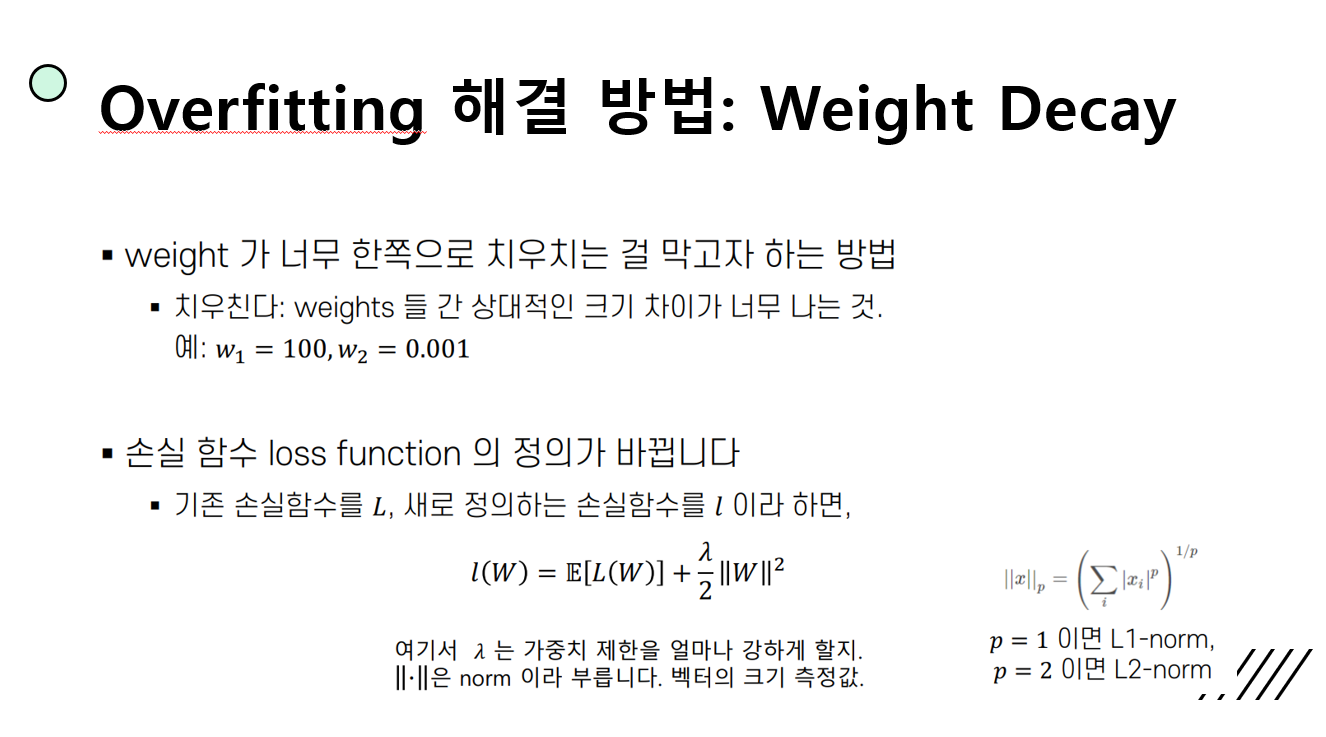

Start training


100%|██████████| 20/20 [13:25<00:00, 40.30s/it]


Done!


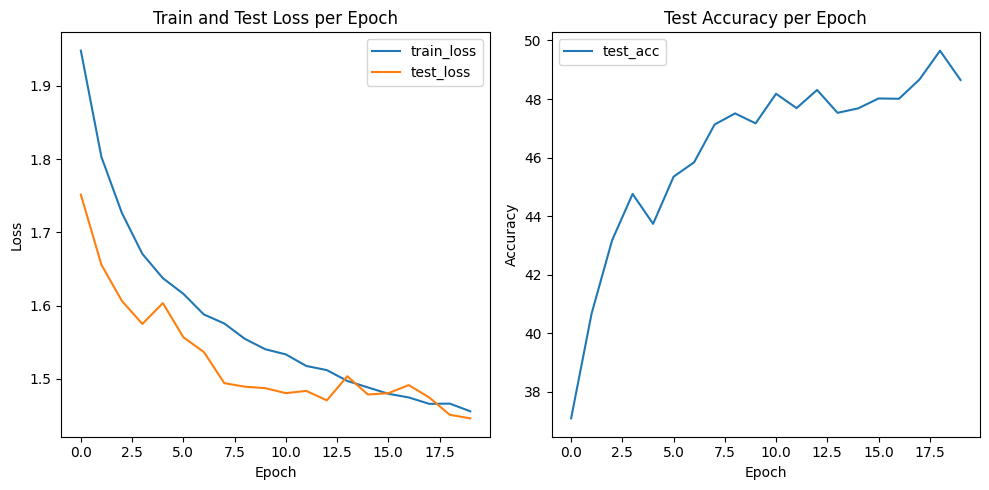

In [ ]:
# Weight Decay

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0.0001
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

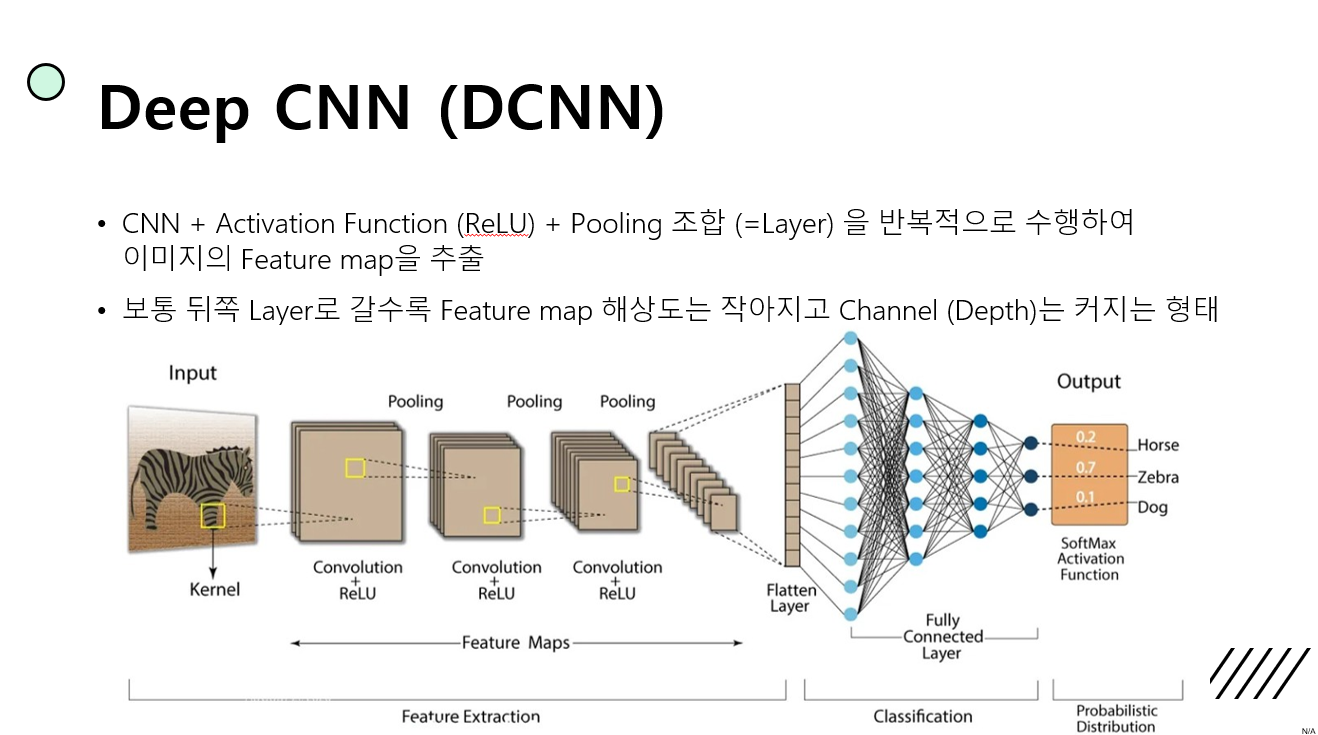

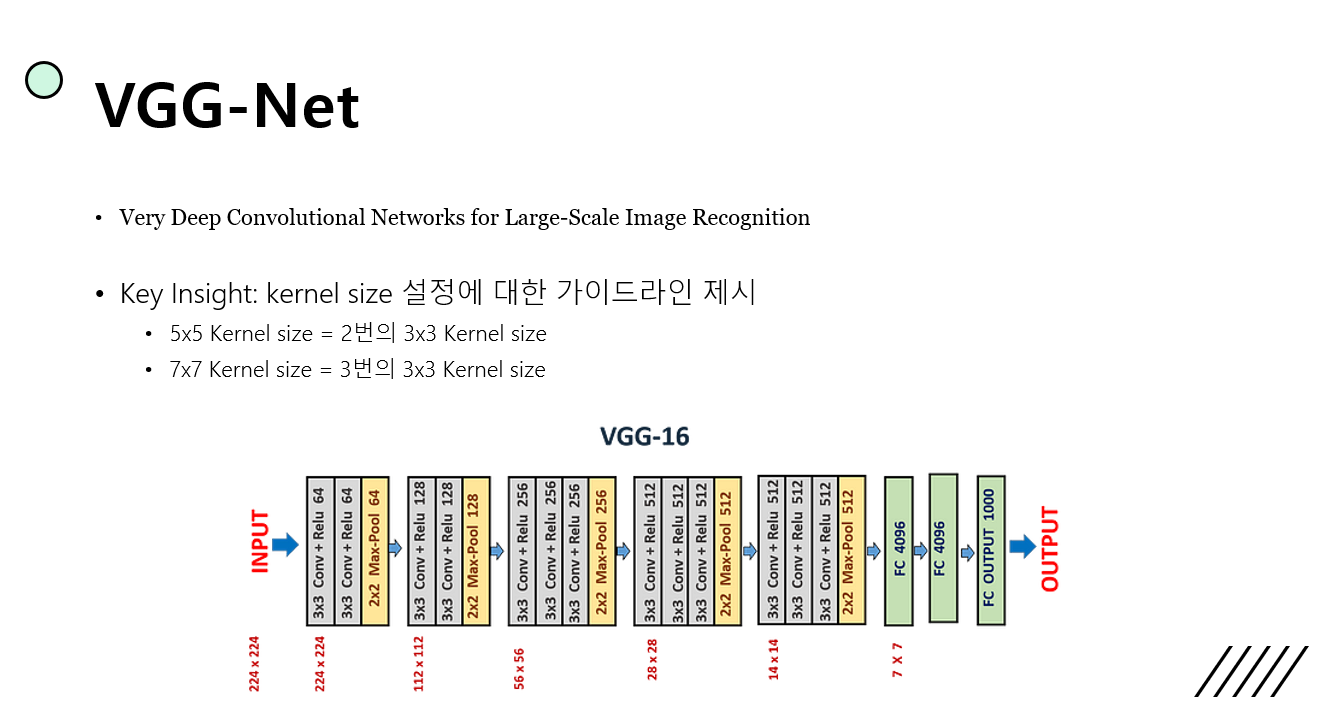

Files already downloaded and verified
Start training


100%|██████████| 20/20 [12:45<00:00, 38.27s/it]


Done!


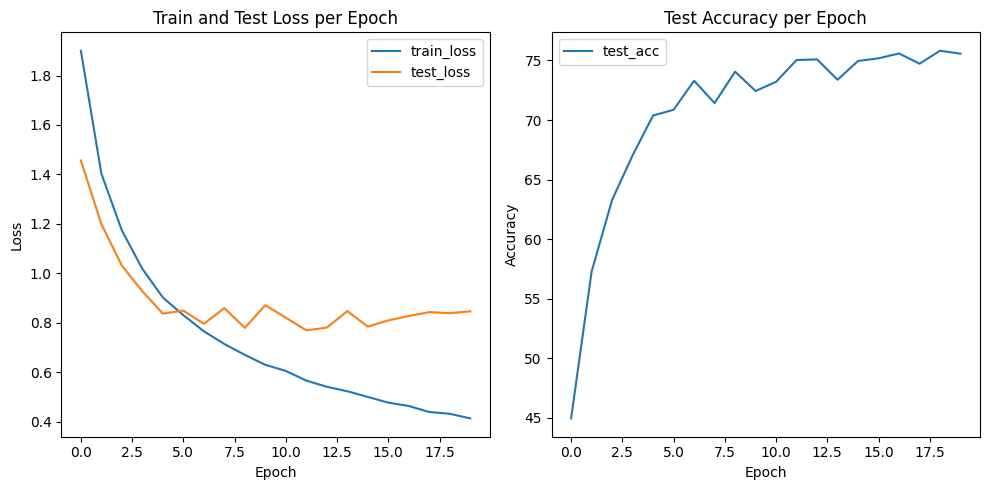

In [ ]:
# VGG-11
learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(), # 이미지 수평으로 뒤집기
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # 이미지 색상 랜덤하게 변경
        transforms.ToTensor()])
)
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

class VGG11(nn.Module):
    def __init__(self, ):
        super(VGG11, self).__init__()

        # Define the Convolutional and Pooling layers

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 64 x 16 x 16
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 128 x 8 x 8
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output: 256 x 4 x 4
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 512 x 2 x 2
        )

        # Define the Fully Connected layers
        self.fc = nn.Sequential(
            nn.Linear(512 * 2 * 2, 1024),  # flatten feature maps 512x2x2 -> 2048
            nn.ReLU(inplace=True),
            #nn.Dropout(),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Forward pass through the feature extraction layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Flatten the output for the fully connected layers
        x = x.view(x.size(0), -1)

        # Forward pass through the classifier
        x = self.fc(x)

        return x

model = VGG11().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

Files already downloaded and verified
Start training


100%|██████████| 20/20 [14:35<00:00, 43.76s/it]


Done!


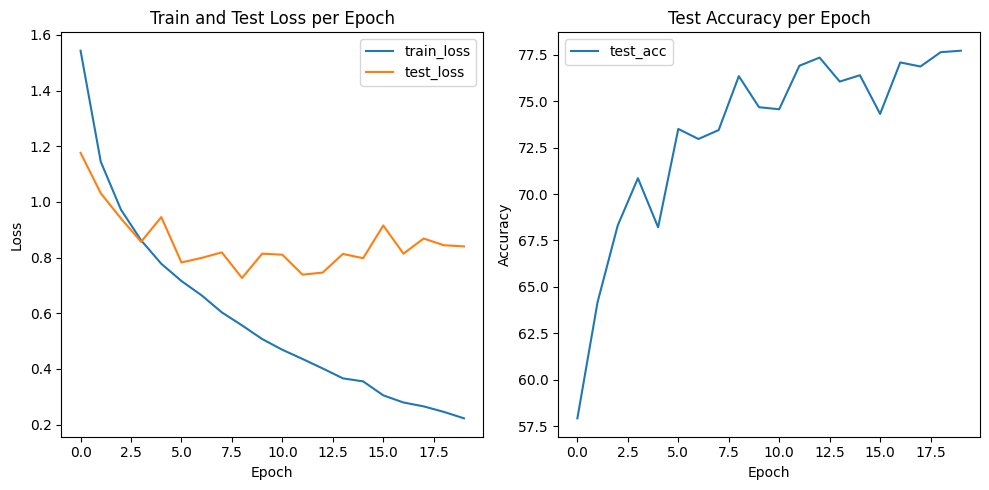

In [ ]:
# ResNet
import torchvision.models as models

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(), # 이미지 수평으로 뒤집기
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # 이미지 색상 랜덤하게 변경
        transforms.ToTensor()])
)
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

# Load ResNet from torchvision.models
model = models.resnet18(weights=None)

# Modify the final fully connected layer for custom number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

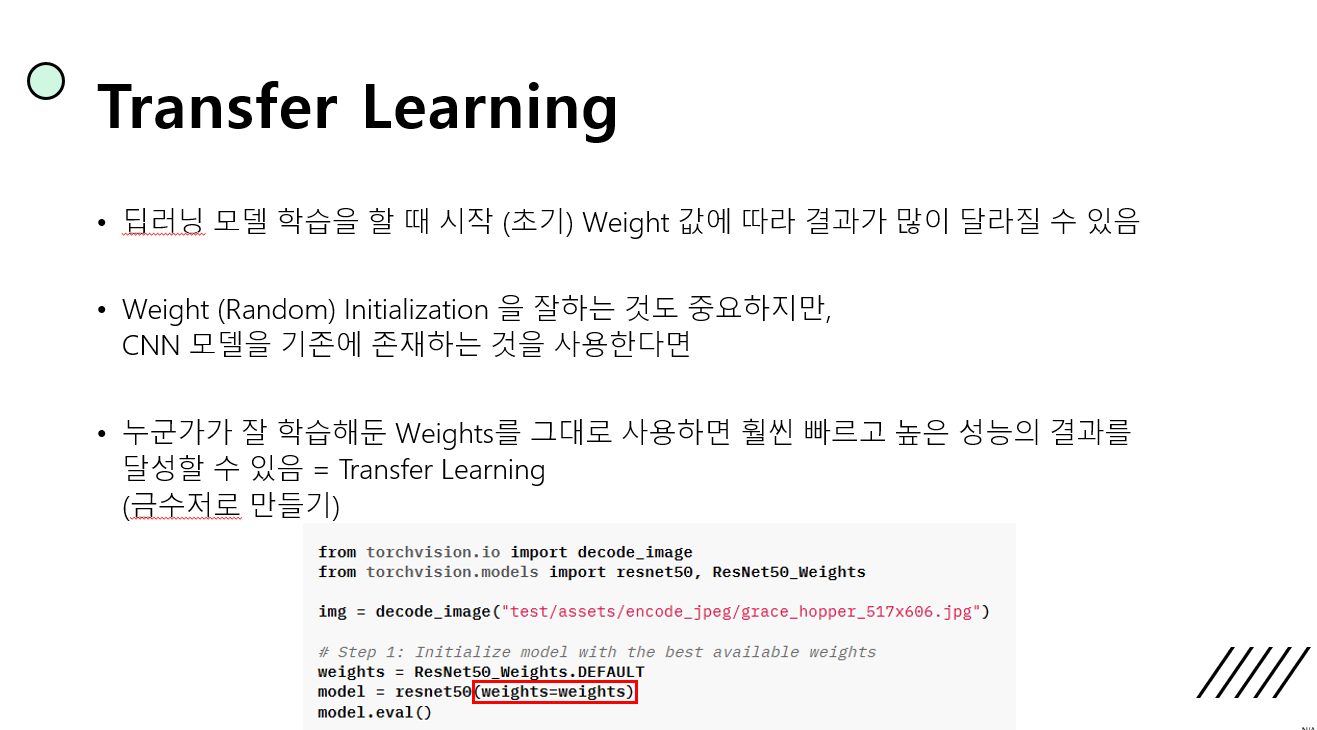

Files already downloaded and verified


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 88.4MB/s]


Start training


100%|██████████| 20/20 [14:11<00:00, 42.59s/it]


Done!


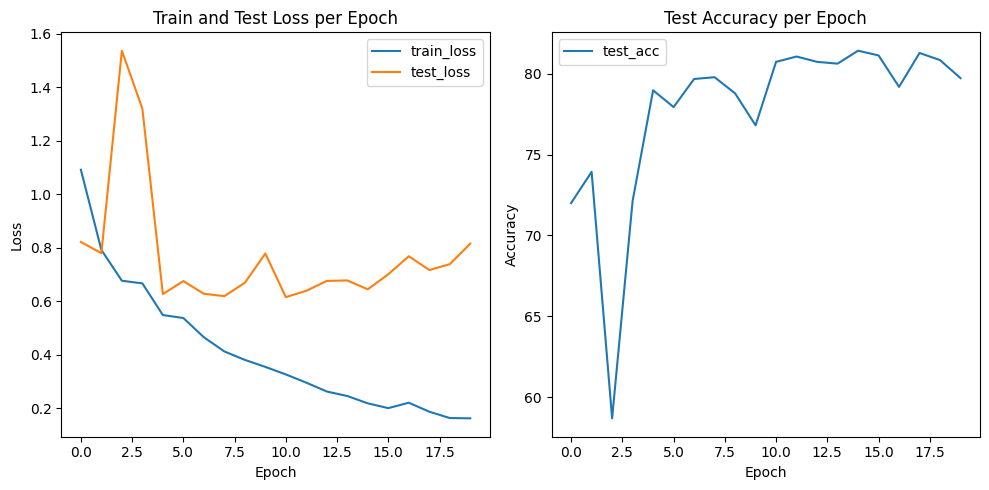

In [ ]:
# Transfer Learning
import torchvision.models as models

learning_rate = 1e-3
batch_size = 64
epochs = 20
weight_decay = 0

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(), # 이미지 수평으로 뒤집기
        transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.2), # 이미지 색상 랜덤하게 변경
        transforms.ToTensor()])
)
train_dataloader = DataLoader(training_data, batch_size=batch_size, num_workers=2, pin_memory=True)

# Load ResNet from torchvision.models with pretraiend weights
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Modify the final fully connected layer for custom number of classes
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

# Assignment 3

Use your own training settings.

- leanring rate
- batch_size
- epochs
- optimizer (https://pytorch.org/docs/stable/optim.html#algorithms)
- weight_decay
- network (https://pytorch.org/vision/main/models.html#classification)

In [ ]:
# Your settings
import torchvision.models as models

learning_rate = 0.001
batch_size = 64
epochs = 10
weight_decay = 0.1

training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.RandomHorizontalFlip(),       # 좌우 반전
        transforms.RandomCrop(32, padding=4),    # 랜덤 크롭 및 패딩
        transforms.RandomRotation(15),           # 랜덤 회전 (최대 15도)
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # 색상, 밝기 등 조정
        transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),  # 랜덤 영역 지우기
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))  # 정규화
    ])
)
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

model = models.resnet18
model = model().to(device)

my_optim = torch.optim.Adam # ex) torch.optim.Adam
optimizer = my_optim(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_loss_list = []
test_loss_list = []
test_acc_list = []

print("Start training")
for t in tqdm(range(epochs)):
    #print(f"-------------------------------\nEpoch {t+1}")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer, device)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn, device)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
print("Done!")

log_results(train_loss_list, test_loss_list, test_acc_list)

Files already downloaded and verified
Start training


  0%|          | 0/10 [00:00<?, ?it/s]


AttributeError: 'Image' object has no attribute 'shape'